In [295]:
import pandas as pd
import geopandas as gpd
import numpy as np
from geopy.distance import geodesic
from quetzal.model import stepmodel
from quetzal.io.display import all_pt_paths, path, pt_path

In [296]:
pwd

'/Users/codygelbrich/Desktop/nic/Term_Paper/codycode'

In [297]:
# Load the network model from the last exercise
model_path = '../../model/'
sm = stepmodel.read_json(model_path + 'network')

In [298]:
# How many zones do we have?
len(sm.zones)

11

## Preparation of OD-times

The pathfinders need a column "time" in the links or road_links tables to find the shortest paths. The PT pathfinder also applies a generalized boarding time (can be interpreted as a penalty for interchanging between transport carriers) and a waiting time, which is computed from the headway of PT carriers (waiting time equals half the headway (in seconds) assuming a randomly and evenly distributed arrival pattern of passengers on every PT stop).

In [299]:
sm.road_links.sample(1)

,a,b,length,geometry,highway
index,,,,,
3387,662761999,270915091,44.804,"LINESTRING (9.48195 54.79743, 9.48195 54.79703)",residential


In [300]:
sm.links.sample(1)

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,disaggregated_a,disaggregated_b,geometry
index,,,,,,,,,,,,,,,
link_1320,710_3,n_66,n_141,10,60.0,14400,710_3,710,59,0,136,bus,node_277642,node_197683,"LINESTRING (9.43392 54.78970, 9.43373 54.79226)"


In [301]:
# We don't see any length column in our links,
# but it is nice for calculating speeds and for later steps.
# We can cast the PT network onto the road network (as in A40)
# Start with the bus links
bus = sm.copy() # copy the whole model
bus.links = bus.links.loc[bus.links['route_type'].isin(['bus'])] # Filter
# Apply quetzal's casting function
bus.preparation_cast_network(
    nearest_method='nodes',
    n_neighbors_centroid=5, 
    n_neighbors=5, 
    penalty_factor=2,
    replace_nodes=False
)

5054_3: 100%|███████████████████████████████████| 99/99 [00:04<00:00, 23.91it/s]


In [302]:
bus.links.sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,disaggregated_a,disaggregated_b,road_a,road_b,road_node_list,road_link_list,road_length,geometry
index,,,,,,,,,,,,,,,,,,,,
link_1397,7592_0,n_68,n_155,19,120.0,1920,7592_0,7592,59,0,136,bus,node_423625,node_68396,287620608,264797657,"[287620608, 264797640, 264797641, 264797650, 2...","[4665, 4666, 4668, 577]",626.062,"LINESTRING (9.463801699999999 54.7750157, 9.46..."


In [303]:
# Now take the road_length of casted model (erstellte Modell) as the length of our genuine model (originale Model)
sm.links['length'] = np.nan # create a new column with default values
sm.links.loc[sm.links['route_type'].isin(['bus']),
             'length'] = bus.links['road_length']

#erstellt neue Spalte in links mit dem Namen length. Dort werden die Längen(road_length) der bus.links gespeichert

In [304]:
# For rail links, we can assign the geometric distance
sm.links.loc[sm.links['length'].isna(), 'length'] = \
    sm.links.loc[sm.links['length'].isna(), 'geometry'].apply(
        lambda l: int(geodesic(l.coords[0], l.coords[-1]).m))
# Take the geometric line and from it the start and end points, then calculate the meter distance in between
#Für die Bahn wird die geometrische Entfernung genutzt

In [305]:
# You can calculate the average bus operation speed
bus = sm.links.loc[sm.links['route_type'] == 'bus'] # filter
bus_lines = bus.groupby('route_id')[['time', 'length']].sum() # sum up time and length for each route
bus_speed = bus['length'].sum() / bus['time'].sum() # operation speed
print('bus_speed =', bus_speed, 'm / s')
#berechnet die Busgeschwindigkeit über die länge der links  und die zeit

bus_speed = 5.969885032067939 m / s


In [306]:
# Create the time LoS column for cars (it's already there for PT from the GTFS feeds)
car_speed = 5.8333333333333 #Binnenverkehr (21km/h) aus Mobilitätsbericht Flensburg 
sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s

In [307]:
sm.road_links

,a,b,length,geometry,highway,time
index,,,,,,
1,26012989,654163464,183.731,"LINESTRING (9.39666 54.76167, 9.39776 54.76015)",secondary,31.496743
2,26012989,654163515,275.879,"LINESTRING (9.39666 54.76167, 9.39766 54.76322)",residential,47.293543
3,26012989,232927838,78.570,"LINESTRING (9.39666 54.76167, 9.39617 54.76232)",secondary,13.469143
4,26012995,1300501795,383.719,"LINESTRING (9.40250 54.75548, 9.40641 54.75809)",tertiary,65.780400
5,26012995,79484077,183.331,"LINESTRING (9.40250 54.75548, 9.40065 54.75422)",tertiary,31.428171
...,...,...,...,...,...,...
8043,269216504,9608933099,5.536,"LINESTRING (9.45950 54.80736, 9.45952 54.80741)",secondary,0.949029
8044,269216505,9608933099,99.247,"LINESTRING (9.46106 54.80734, 9.45952 54.80741)",residential,17.013771
8045,1667040721,9608933099,317.486,"LINESTRING (9.46110 54.81011, 9.45952 54.80741)",secondary,54.426171


In [308]:
len(sm.road_links)

8033

In [309]:
# If we want to compute walking paths on road links, we need a time for that to
sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car

### Walk

In [310]:
sm.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

In [311]:
#sm.links

In [312]:
#Same for walking:
sm.footpath_links.sample(1)

,a,b,length,geometry,highway
index,,,,,
57120,1889786916,1889786957,67.918,"LINESTRING (9.47876 54.80814, 9.47882 54.80875)",path


In [313]:
sm.links.sample(1)

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,disaggregated_a,disaggregated_b,geometry,length
index,,,,,,,,,,,,,,,,
link_797,4311_2,n_197,n_61,9,60.0,1838,4311_2,4311,59,0,136,bus,node_383479,node_412757,"LINESTRING (9.42970 54.77132, 9.42556 54.77161)",203.074


In [314]:
walk = sm.copy() # Copy the whole model and save it as 'walk'

In [315]:
walk.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

In [316]:
walk.road_links = walk.footpath_links # Act as if the walking links were road links
walk.road_nodes = walk.footpath_nodes # Same for nodes

In [317]:
walk.road_links.sample()

,a,b,length,geometry,highway
index,,,,,
6396,312251612,320859950,50.452,"LINESTRING (9.47545 54.80226, 9.47551 54.80181)",tertiary


In [318]:
walk.links.sample()

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,disaggregated_a,disaggregated_b,geometry,length
index,,,,,,,,,,,,,,,,
link_1127,5054_5,n_153,n_259,5,60.0,86400,5054_5,5054,59,0,136,bus,node_7543,node_383316,"LINESTRING (9.44449 54.78767, 9.44769 54.79065)",412.417


In [319]:
#walk.links['route_type'] = 'walk'

In [320]:
#walk.links.sample()

In [321]:
#walk.links = walk.links.loc[walk.links['route_type'].isin(['walk'])] # Filter

In [322]:
#walk.links.sample()

In [323]:
walk.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

In [324]:
# Now take the road_length of casted model (erstellte Modell) as the length of our genuine model (originale Model)
#walk.links['length'] = np.nan # create a new column with default values
# --> es gibt bereits eine spalte mit length

In [325]:
#walk.links.sample()

In [326]:
#sm.links.loc[sm.links['route_type'].isin(['walk'])] # Filter

In [327]:
# Create the time LoS column for walking
walk_speed = 1.3888888888889 #Binnenverkehr & Wege unter 5km --> 5km/h aus Mobilitätsbericht Flensburg 
sm.footpath_links['time'] = sm.footpath_links['length'] / walk_speed # m/s
walk.road_links['time'] = walk.road_links['length'] / walk_speed

In [328]:
# If we want to compute walking paths on road links, we need a time for that to
sm.footpath_links['walk_time'] = sm.footpath_links['time'] * 1 # walk same time

In [329]:
walk.road_links


,a,b,length,geometry,highway,time
index,,,,,,
1,21929576,9077610843,6.139,"LINESTRING (9.46856 54.82250, 9.46864 54.82253)",path,4.42008
2,21929576,1851263511,31.839,"LINESTRING (9.46856 54.82250, 9.46815 54.82266)",path,22.92408
3,21929576,3417612920,47.207,"LINESTRING (9.46856 54.82250, 9.46917 54.82227)",path,33.98904
4,26012979,1288301276,25.413,"LINESTRING (9.38537 54.77486, 9.38504 54.77473)",service,18.29736
5,26012979,2021498995,9.452,"LINESTRING (9.38537 54.77486, 9.38549 54.77491)",path,6.80544
...,...,...,...,...,...,...
64236,9918461081,9918461067,3.670,"LINESTRING (9.43406 54.79266, 9.43401 54.79265)",path,2.64240
64237,9918461067,9918461081,3.670,"LINESTRING (9.43401 54.79265, 9.43406 54.79266)",path,2.64240
64238,1819999174,9929181776,8.573,"LINESTRING (9.45075 54.77648, 9.45062 54.77646)",service,6.17256


In [330]:
sm.road_links.sample(1)

,a,b,length,geometry,highway,time,walk_time
index,,,,,,,
7817,1779120370,1779120363,99.017,"LINESTRING (9.42646 54.80730, 9.42560 54.80683)",residential,16.974343,50.923029


In [331]:
sm.footpath_links.sample(1)

,a,b,length,geometry,highway,time,walk_time
index,,,,,,,
38062,997610446,297323550,84.974,"LINESTRING (9.46750 54.76859, 9.46755 54.76936)",path,61.18128,61.18128


### Cycle

In [332]:
sm.bikelane_links.sample(1)

,a,b,length,geometry,highway
index,,,,,
46101,1797435136,1797435123,41.278,"LINESTRING (9.47121 54.79442, 9.47176 54.79423)",service


In [333]:
sm.links.sample(1)

,trip_id,a,b,link_sequence,time,headway,pattern_id,route_id,service_id,direction_id,agency_id,route_type,disaggregated_a,disaggregated_b,geometry,length
index,,,,,,,,,,,,,,,,
link_1102,5054_4,n_180,n_89,6,60.0,21600,5054_4,5054,59,0,136,bus,node_358908,node_75875,"LINESTRING (9.46405 54.80916, 9.46069 54.80965)",171.173


In [334]:
bike = sm.copy() # Copy the whole model and save it as 'bike'

In [335]:
bike.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

In [336]:
bike.road_links = bike.bikelane_links # Act as if the walking links were road links
bike.road_nodes = bike.bikelane_nodes # Same for nodes

In [337]:
bike.road_links.sample()

,a,b,length,geometry,highway
index,,,,,
54738,2333576417,2333576422,43.663,"LINESTRING (9.48284 54.77310, 9.48347 54.77323)",residential


In [338]:
bike.road_nodes.sample()

,geometry
index,
295637926,POINT (9.45280 54.80231)


In [339]:
#codes mit .links ausgelassen (da eigentlich nur für PT?)

In [340]:
# Create the time LoS column for walking
cycling_speed = 3.6111111111111 #Binnenverkehr 3.6111111111111 (13km/h) aus Mobilitätsbericht Flensburg (Durchschnitt Entfernung unter 5km und bis 10km)
sm.bikelane_links['time'] = sm.bikelane_links['length'] / cycling_speed # m/s
bike.road_links['time'] = bike.road_links['length'] / cycling_speed

In [341]:
# If we want to compute walking paths on road links, we need a time for that to
sm.bikelane_links['walk_time'] = sm.bikelane_links['time'] * 3.36 # walk time 1.25m/s

In [342]:
bike.road_links

,a,b,length,geometry,highway,time
index,,,,,,
1,21929576,9077610843,6.139,"LINESTRING (9.46856 54.82250, 9.46864 54.82253)",path,1.700031
2,21929576,1851263511,31.839,"LINESTRING (9.46856 54.82250, 9.46815 54.82266)",path,8.816954
3,21929576,3417612920,47.207,"LINESTRING (9.46856 54.82250, 9.46917 54.82227)",path,13.072708
4,26012979,1288301276,25.413,"LINESTRING (9.38537 54.77486, 9.38504 54.77473)",service,7.037446
5,26012979,2021498995,9.452,"LINESTRING (9.38537 54.77486, 9.38549 54.77491)",path,2.617477
...,...,...,...,...,...,...
59745,9918461081,9918461067,3.670,"LINESTRING (9.43406 54.79266, 9.43401 54.79265)",path,1.016308
59746,9918461067,9918461081,3.670,"LINESTRING (9.43401 54.79265, 9.43406 54.79266)",path,1.016308
59747,1819999174,9929181776,8.573,"LINESTRING (9.45075 54.77648, 9.45062 54.77646)",service,2.374062


In [343]:
sm.bikelane_links.sample(1)

,a,b,length,geometry,highway,time,walk_time
index,,,,,,,
41972,1688523241,1688523259,68.154,"LINESTRING (9.44059 54.76520, 9.44159 54.76540)",residential,18.873415,63.414676


## Pathfinding

Next, we want to create a table of OD-relations for different modes, each, being representative for the performance of a specific mode on a specific OD pair.

Quetzal has multiple options for path finding, seperated into one function wrapper for road and one for PT. They create the `car_los` and `pt_los tables`, respectively.

For road transport, quetzal can simply compute one shortest path per OD pair or multiple ones if you had the capacities and volumes already saved in the model (comes from the assignment step at the very end). So, we just compute one path for now (`all_or_nothing=True`)

The PT pathfinder has two relevant attributes: `broken_modes` and `broken_routes`. If both are `False`, the pathfinder just searches for the shortest path between every OD pair, considering all PT modes and routes. If `broken_modes=True`, the pathfinder searches shortest paths for every possible mode combination. If `broken_routes=True`, the pathfinder searches shortest paths for every possible route combination. 
Additionally you can decide whether walking connections shall be done on roadsides or not with the `walk_on_road` parameter (question of computation time).

### Car

In [344]:
# Simple road pathfinder
sm.step_road_pathfinder(all_or_nothing=True)

In [345]:
len(sm.car_los)

121

In [346]:
sm.car_los.sample(5)

,origin,destination,time,path,node_path,link_path,ntlegs
12,zone_1,zone_1,0.000000,[zone_1],[],[],[]
64,zone_4,zone_8,1083.615067,"[zone_4, 325712391, 271098146, 315549401, 3155...","[325712391, 271098146, 315549401, 315549404, 3...","[5173, 6401, 6405, 6407, 6562, 5033, 6661, 772...","[(zone_4, 325712391), (310597434, zone_8)]"
6,zone_0,zone_5,517.204336,"[zone_0, 272871873, 272871697, 272871872, 2739...","[272871873, 272871697, 272871872, 273951209, 4...","[5418, 5423, 5460, 7128, 5463, 5483, 5350, 534...","[(zone_0, 272871873), (256372220, zone_5)]"
49,zone_3,zone_4,1397.117497,"[zone_3, 275240057, 248823783, 391535532, 2749...","[275240057, 248823783, 391535532, 274939007, 2...","[4412, 6941, 5606, 4809, 4811, 4687, 4683, 427...","[(zone_3, 275240057), (325712391, zone_4)]"
118,zone_9,zone_7,1157.847062,"[zone_9, 261584189, 261585311, 261576869, 4011...","[261584189, 261585311, 261576869, 40112820, 23...","[4524, 4514, 4248, 4362, 181, 7071, 4396, 4365...","[(zone_9, 261584189), (1688523512, zone_7)]"


In [347]:
# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = sm.road_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
sm.car_los['length'] = sm.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

In [348]:
# add the route type for sake of consistency
sm.analysis_car_route_type()

In [349]:
sm.car_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
73,zone_5,zone_6,1093.389284,"[zone_5, 256372220, 272862385, 256372217, 2652...","[256372220, 272862385, 256372217, 265286398, 2...","[354, 1383, 353, 4727, 651, 310, 3229, 23, 331...","[(zone_5, 256372220), (340042073, zone_6)]",5149.855,"(car,)",car


In [350]:
sm.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

### Walk

In [351]:
walk.step_road_pathfinder(all_or_nothing=True) # Find shortest paths

In [352]:
walk.__dict__.keys() #in (walk.)car_los sind meine walk_los gespeichert

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

In [353]:
len(walk.car_los)

121

In [354]:
walk.car_los

,origin,destination,time,path,node_path,link_path,ntlegs
0,zone_0,zone_0,0.000000,[zone_0],[],[],[]
1,zone_0,zone_1,2683.769261,"[zone_0, 455190153, 1783775397, 1783775384, 17...","[455190153, 1783775397, 1783775384, 1783775380...","[48218, 48215, 48211, 36435, 43110, 40855, 408...","[(zone_0, 455190153), (232927756, zone_1)]"
2,zone_0,zone_10,2677.143919,"[zone_0, 272871873, 272871697, 1783775445, 273...","[272871873, 272871697, 1783775445, 273957495, ...","[35341, 48242, 35454, 35354, 35459, 40804, 482...","[(zone_0, 272871873), (268370790, zone_10)]"
3,zone_0,zone_2,3200.883655,"[zone_0, 272871873, 272871697, 1783775445, 273...","[272871873, 272871697, 1783775445, 273957495, ...","[35341, 48242, 35454, 35354, 35459, 40804, 482...","[(zone_0, 272871873), (287252470, zone_2)]"
4,zone_0,zone_3,2303.367050,"[zone_0, 272871873, 272871697, 1784407787, 272...","[272871873, 272871697, 1784407787, 272871872, ...","[35341, 48280, 35343, 35434, 48254, 40679, 625...","[(zone_0, 272871873), (275240057, zone_3)]"
...,...,...,...,...,...,...,...
116,zone_9,zone_5,2343.689182,"[zone_9, 261584351, 1828711638, 1828711646, 18...","[261584351, 1828711638, 1828711646, 1828711678...","[53300, 53303, 53305, 33385, 53314, 53317, 325...","[(zone_9, 261584351), (276173474, zone_5)]"
117,zone_9,zone_6,5494.129631,"[zone_9, 261584351, 1828711638, 1828711646, 18...","[261584351, 1828711638, 1828711646, 1828711678...","[53300, 53303, 53305, 33385, 53314, 53317, 325...","[(zone_9, 261584351), (340042073, zone_6)]"
118,zone_9,zone_7,3231.964659,"[zone_9, 261602220, 261607602, 1828519845, 182...","[261602220, 261607602, 1828519845, 1828519855,...","[32965, 53149, 53152, 32967, 60779, 45929, 406...","[(zone_9, 261602220), (1688523652, zone_7)]"
119,zone_9,zone_8,5821.593700,"[zone_9, 261602220, 261607602, 1828519845, 182...","[261602220, 261607602, 1828519845, 1828519855,...","[32965, 53149, 53152, 32967, 60779, 45929, 406...","[(zone_9, 261602220), (310597434, zone_8)]"


In [355]:
# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = walk.footpath_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
walk.car_los['length'] = walk.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

In [356]:
# add the route type for sake of consistency
walk.analysis_car_route_type()
#???

In [357]:
# Save shortest paths table (LoS) in 'sm' and don't use 'walk' anymore
sm.walk_los = walk.car_los
#sm.footpath_links = walk.footpath_links # --> hier fehler?

In [358]:
sm.walk_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
38,zone_2,zone_4,2276.762434,"[zone_2, 287252470, 2371511189, 287261892, 287...","[287252470, 2371511189, 287261892, 287262036, ...","[58596, 37172, 37178, 54313, 37173, 37183, 626...","[(zone_2, 287252470), (325712391, zone_4)]",2722.641,"(car,)",car


In [359]:
sm.walk_los['route_types'] = [('walk',) for i in sm.walk_los.index]

In [360]:
sm.walk_los['route_type'] = 'walk'

In [361]:
sm.walk_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
85,zone_6,zone_7,4507.514253,"[zone_6, 340042073, 1376866601, 1827690894, 13...","[340042073, 1376866601, 1827690894, 1376866574...","[43384, 52391, 43373, 43368, 43361, 43358, 523...","[(zone_6, 340042073), (1817875389, zone_7)]",5586.085,"(walk,)",walk


In [362]:
sm.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

### Bike

In [363]:
bike.step_road_pathfinder(all_or_nothing=True) # Find shortest paths

In [364]:
bike.__dict__.keys() #in (bike.)car_los sind meine bike_los gespeichert

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

In [365]:
len(bike.car_los)

121

In [366]:
bike.car_los

,origin,destination,time,path,node_path,link_path,ntlegs
0,zone_0,zone_0,0.000000,[zone_0],[],[],[]
1,zone_0,zone_1,1243.768870,"[zone_0, 272871873, 272871697, 1783775445, 273...","[272871873, 272871697, 1783775445, 273957495, ...","[32879, 44860, 32981, 37932, 44836, 44833, 448...","[(zone_0, 272871873), (654163515, zone_1)]"
2,zone_0,zone_10,1303.153297,"[zone_0, 272871873, 272871697, 1784407787, 272...","[272871873, 272871697, 1784407787, 272871872, ...","[32879, 44895, 32881, 32961, 44875, 37888, 449...","[(zone_0, 272871873), (268370790, zone_10)]"
3,zone_0,zone_2,1385.544942,"[zone_0, 272871873, 272871697, 1784407787, 272...","[272871873, 272871697, 1784407787, 272871872, ...","[32879, 44895, 32881, 32961, 44875, 37888, 449...","[(zone_0, 272871873), (287252470, zone_2)]"
4,zone_0,zone_3,984.285235,"[zone_0, 272871873, 272871697, 1784407787, 272...","[272871873, 272871697, 1784407787, 272871872, ...","[32879, 44895, 32881, 32961, 44868, 37765, 583...","[(zone_0, 272871873), (275240057, zone_3)]"
...,...,...,...,...,...,...,...
116,zone_9,zone_5,1059.278361,"[zone_9, 261602220, 261607602, 1828519845, 182...","[261602220, 261607602, 1828519845, 1828519855,...","[30830, 49567, 49570, 30832, 56869, 49626, 308...","[(zone_9, 261602220), (256372220, zone_5)]"
117,zone_9,zone_6,2274.922982,"[zone_9, 261602220, 261607602, 1828519845, 182...","[261602220, 261607602, 1828519845, 1828519855,...","[30830, 49567, 49570, 30832, 56869, 42662, 377...","[(zone_9, 261602220), (340042073, zone_6)]"
118,zone_9,zone_7,1457.997311,"[zone_9, 261602220, 261607602, 1828519845, 182...","[261602220, 261607602, 1828519845, 1828519855,...","[30830, 49567, 49570, 30832, 56869, 42662, 377...","[(zone_9, 261602220), (1688523652, zone_7)]"
119,zone_9,zone_8,2476.750844,"[zone_9, 261602220, 261607602, 1828519845, 182...","[261602220, 261607602, 1828519845, 1828519855,...","[30830, 49567, 49570, 30832, 56869, 42662, 377...","[(zone_9, 261602220), (310597434, zone_8)]"


In [367]:
# Assign a length to LoS table
# Create a dictionary of road link lengths
len_dict = bike.bikelane_links['length'].to_dict()
# Apply it to the link path column (sum up all links for each path)
bike.car_los['length'] = bike.car_los['link_path'].apply(
    lambda l: sum([len_dict[i] for i in l]))

In [368]:
# add the route type for sake of consistency
bike.analysis_car_route_type()

In [369]:
# Save shortest paths table (LoS) in 'sm' and don't use 'bike' anymore
sm.bike_los = bike.car_los

In [370]:
sm.bike_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
116,zone_9,zone_5,1059.278361,"[zone_9, 261602220, 261607602, 1828519845, 182...","[261602220, 261607602, 1828519845, 1828519855,...","[30830, 49567, 49570, 30832, 56869, 49626, 308...","[(zone_9, 261602220), (256372220, zone_5)]",3191.612,"(car,)",car


In [371]:
sm.bike_los['route_types'] = [('cycling',) for i in sm.bike_los.index]

In [372]:
sm.bike_los['route_type'] = 'cycling'

In [373]:
sm.bike_los.sample()

,origin,destination,time,path,node_path,link_path,ntlegs,length,route_types,route_type
33,zone_2,zone_0,1405.199004,"[zone_2, 287252470, 73221116, 2371511188, 1832...","[287252470, 73221116, 2371511188, 1832312827, ...","[30347, 54913, 50031, 50061, 50028, 54981, 500...","[(zone_2, 287252470), (272871873, zone_0)]",4275.704,"(cycling,)",cycling


In [374]:
sm.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

### PT

In [375]:
# Simple PT
sm.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=False)

path_analysis: 100%|███████████████████████| 121/121 [00:00<00:00, 77164.48it/s]


In [376]:
len(sm.pt_los)

121

In [377]:
sm.pt_los.sample()

,origin,destination,gtime,path,pathfinder_session,reversed,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
32,zone_10,zone_9,2330.6889,"(zone_10, n_79, link_606, link_607, link_608, ...",best_path,False,[n_79],[n_90],"[n_79, n_90]","[link_606, link_607, link_608, link_609, link_...",[],"[(zone_10, n_79), (n_90, zone_9)]",[],[link_606],[link_616],False,0,900.0,5634.754


In [378]:
sm.pt_los.columns

Index(['origin', 'destination', 'gtime', 'path', 'pathfinder_session',
       'reversed', 'boardings', 'alightings', 'node_path', 'link_path',
       'footpaths', 'ntlegs', 'transfers', 'boarding_links', 'alighting_links',
       'all_walk', 'ntransfers', 'time_link_path', 'length_link_path'],
      dtype='object')

In [379]:
sm.links['route_type'].unique()

array(['bus'], dtype=object)

In [380]:
# Add route types to the paths
# The mode that appears first in the hierarchy is assigned as
# main mode, if there is more than one route_type used on the path
hierarchy = ['rail', 'subway', 'funicular', 'tram', 'bus', 'cycle', 'walk']
sm.analysis_pt_route_type(hierarchy)

array([[<AxesSubplot:title={'center':'ntransfers'}>]], dtype=object)

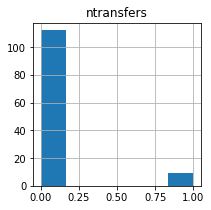

In [381]:
# How many transfers do we have?
sm.pt_los.hist(column='ntransfers', bins=6, figsize=(3,3))

<AxesSubplot:xlabel='route_types'>

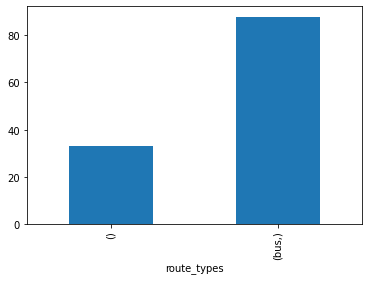

In [382]:
# How many connections do we have per mode combination in the shortest paths?
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

In [383]:
# Now, let's look at the results when we disaggregate paths by route_type
sm.step_pt_pathfinder(broken_modes=True, broken_routes=False, walk_on_road=False)

path_analysis: 100%|███████████████████████| 209/209 [00:00<00:00, 63836.99it/s]


In [384]:
# How many paths do we have now compared to 12,100,208,210 before?
len(sm.pt_los)

209

In [385]:
sm.analysis_pt_route_type(hierarchy)
sm.pt_los.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path,route_types,route_type
57,zone_4,zone_10,3307.720272,"(zone_4, n_52, n_50, n_246, n_190, n_231, n_38...",False,mode_breaker,{bus},[],[],"[n_52, n_50, n_246, n_190, n_231, n_38, n_79]",...,"[(zone_4, n_52), (n_79, zone_10)]",[],[],[],True,0,0.0,0.0,(),walk


<AxesSubplot:xlabel='route_types'>

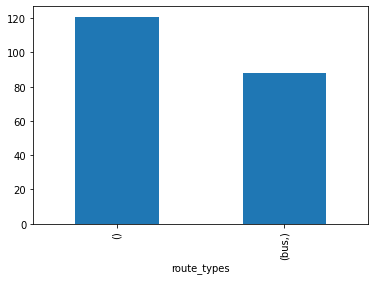

In [386]:
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple) # bugfix
sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

In [387]:
# Compute time attribute (from link path and footpaths and access links)
sm.analysis_pt_time()

In [388]:
# Closer look at one OD pair
sm.pt_los.loc[(sm.pt_los['origin']=='zone_3') & (sm.pt_los['destination']=='zone_10')][
    ['route_types', 'time', 'ntransfers']]

,route_types,time,ntransfers
46,(),4793.212591,0
46,"(bus,)",2729.867412,0


Reprojecting model from epsg 4326 to epsg 3857: 100%|█| 47/47 [00:06<00:00,  7.5
100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  2.61it/s]


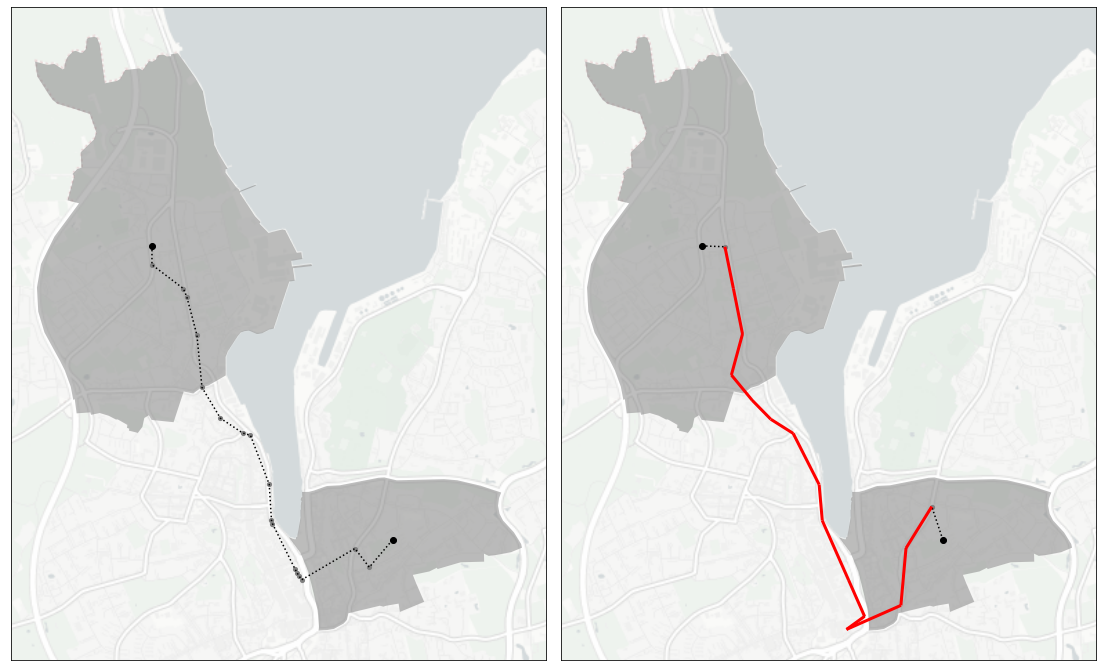

In [389]:
# Plot
plot = sm.change_epsg(3857, coordinates_unit=sm.coordinates_unit)
#plot.links['color'] = '#' + plot.links['route_color']
 
fig, axes = plot.plot_separated_paths(
    'zone_3','zone_10', rows=1, figsize=[16, 16],
    title=None, constrained_layout=True, zoom=13, resize=True,
    basemap_url='http://a.basemaps.cartocdn.com/light_nolabels/tileZ/tileX/tileY.png', 
)

In [390]:
# Assign a length to LoS table
sm.analysis_pt_length()

<AxesSubplot:>

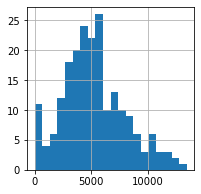

In [391]:
# Length distribution
sm.pt_los['length'].hist(bins=20, figsize=(3,3))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

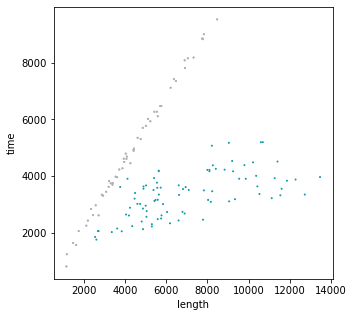

In [392]:
# Dependency between distance and time
mask = sm.pt_los['origin']!=sm.pt_los['destination'] # Filter statement
color_dict = {'bus': '#129eac', 'subway': '#0e5899', 'tram': '#5ea8e8', 'rail': '#1F85DE', 'walk': '#adb3b4'}
color_list = [color_dict[t] for t in sm.pt_los.loc[mask, 'route_type']]
ax = sm.pt_los.loc[mask].plot(
    kind='scatter', x='length', y='time', figsize=[5, 5], s=1, c=color_list)
ax.legend(handles=color_list, labels=sm.pt_los.loc[mask, 'route_type'])

In [394]:
# Plot all paths between zones including car
path(sm, 'zone_3', 'zone_5', public=True, private=True,)
#???

In [395]:
sm.__dict__.keys()

dict_keys(['parameters', 'debug', 'walk_on_road', 'coordinates_unit', 'epsg', 'segments', 'checkpoint_links', 'loaded_links', 'links', 'road_links', 'footpaths', 'lines', 'networkcaster_neighbors', 'networkcaster_road_access', 'node_parenthood', 'road_to_transit', 'zone_to_transit', 'zone_to_road', 'checkpoint_nodes', 'loaded_nodes', 'nodes', 'road_nodes', 'centroids', 'disaggregated_nodes', 'micro_zones', 'zones', 'node_clusters', 'fare_rules', 'fare_attributes', 'mode_nests', 'logit_scales', 'utility_values', 'car_los', 'cycling_los', 'cycle_los', 'walk_los', 'jsons', 'bike_los', 'volumes', 'pt_los', 'footpath_links', 'dead_ends', 'circular_lines', 'broken_sequences', 'bikelane_links', 'footpath_nodes', 'bikelane_nodes'])

## Prices

Add price LoS attribute to LoS tables

In [396]:
# Car usage has operating cost of 13ct/km in average
# Note: we don't apply sunk cost like maintenance or purchase cost
sm.car_los['price'] = sm.car_los['length'] * 0.13 / 1000

In [397]:
# For PT, we have a look at the PT operators price structure.
# For this toy model we simplify it to day tickets:
# https://www.aktiv-bus.de/fahrkarten/flensburg/
# Assume that a passenger makes two trips per day with a day ticket
sm.pt_los['price'] = 6/3.2 
# We don't re-build the exact price structure, but make longer trips more expensive
#sm.pt_los.loc[sm.pt_los['length']>10000, 'price'] = 10 / 2

In [398]:
#Fürs Gehen muss man nichts bezahlen
sm.walk_los['price']= 0  

In [399]:
#Fürs Radfahren muss man nichts bezahlen
sm.bike_los['price']= 0 

In [400]:
sm.pt_los.reset_index(inplace=True)

## Save model

In [401]:
sm.to_json(model_path + 'los_tables')

to_hdf(overwriting):  62%|█████████████▌        | 29/47 [00:02<00:01, 12.73it/s]

could not save geometry from table fare_rules
could not save geometry from table fare_attributes
could not save geometry from table mode_nests
could not save geometry from table logit_scales
could not save geometry from table utility_values


to_hdf(overwriting): 100%|██████████████████████| 47/47 [00:13<00:00,  3.54it/s]
